<a href="https://colab.research.google.com/github/nabinyd/60-Days-of-learning/blob/main/DLPT_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Custom Datasets
# Day 23

  ##  0. Importing PyToch and setting up device-agnostic code
  

In [1]:
import torch
from torch import nn

torch.__version__

'2.3.0+cu121'

In [2]:
#  Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cpu'

## 1. Get data

our dataset is a subset of the Food101 dataset.

Food101 starts 101 different classes of food and 1000 images per class (750 training, 250 testing)

Our dataset starts with classes of food and only 10% of the images. (~75 training, 25  testing).

Why do this?

When starting out ML projects, it's important to try things on a small scale and then increase the scale when necessary.


In [3]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizaa_steak_sushi"

# If the image folder doesnt exist, download it and prepare it...
if image_path.is_dir():
  print(f"{image_path} directory a;ready exists... skipping download")
else:
  print(f"{image_path} does not exist, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

  # Downlaod pizza, steak and sushi data
  with open(data_path / "pizza_steak_sushi.zip","wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downlooading pizza, steak, sushi data...")
    f.write(request.content)

data/pizaa_steak_sushi does not exist, creating one...
Downlooading pizza, steak, sushi data...


In [4]:
# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza, steak and sushi data..")
  zip_ref.extractall(image_path)

Unzipping pizza, steak and sushi data..


## 2. Becoming one with the data (data preparation and data exploration)

In [5]:
import os
def walK_through_dir(dir_path):
  """Walks through dir_path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'. ")

In [6]:
walK_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizaa_steak_sushi'. 
There are 3 directories and 0 images in 'data/pizaa_steak_sushi/train'. 
There are 0 directories and 75 images in 'data/pizaa_steak_sushi/train/steak'. 
There are 0 directories and 78 images in 'data/pizaa_steak_sushi/train/pizza'. 
There are 0 directories and 72 images in 'data/pizaa_steak_sushi/train/sushi'. 
There are 3 directories and 0 images in 'data/pizaa_steak_sushi/test'. 
There are 0 directories and 19 images in 'data/pizaa_steak_sushi/test/steak'. 
There are 0 directories and 25 images in 'data/pizaa_steak_sushi/test/pizza'. 
There are 0 directories and 31 images in 'data/pizaa_steak_sushi/test/sushi'. 


In [7]:
#  Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"


train_dir, test_dir

(PosixPath('data/pizaa_steak_sushi/train'),
 PosixPath('data/pizaa_steak_sushi/test'))

 ### 2.1 Visualizing and image

 Let's write some code to:
 1. Get all of the ransom paths
 2. Pick a random image path using Python's random.choice()
 3. Get the image class name using `pathlib.Path.parent.stem`
 4. Since we're working with images, let's open the image with Python's PIL

 5. We'll then show the image and print metadata

data/pizaa_steak_sushi/test/sushi/46797.jpg
sushi
Random image path: data/pizaa_steak_sushi/test/sushi/46797.jpg
Image class: sushi
Image height: 384
Image width: 512


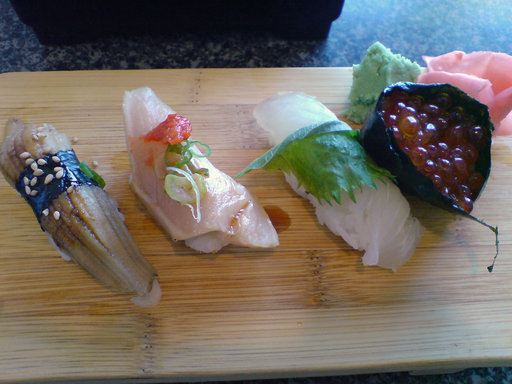

In [8]:
import random
from PIL import Image

# Set seed
# random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)
print(random_image_path)

# 3. Get image class form path name (the image class is the name of the directroy where the image the image is stored)
image_class = random_image_path.parent.stem
print(image_class)

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")

img



In [9]:
# image_path_list

(-0.5, 511.5, 383.5, -0.5)

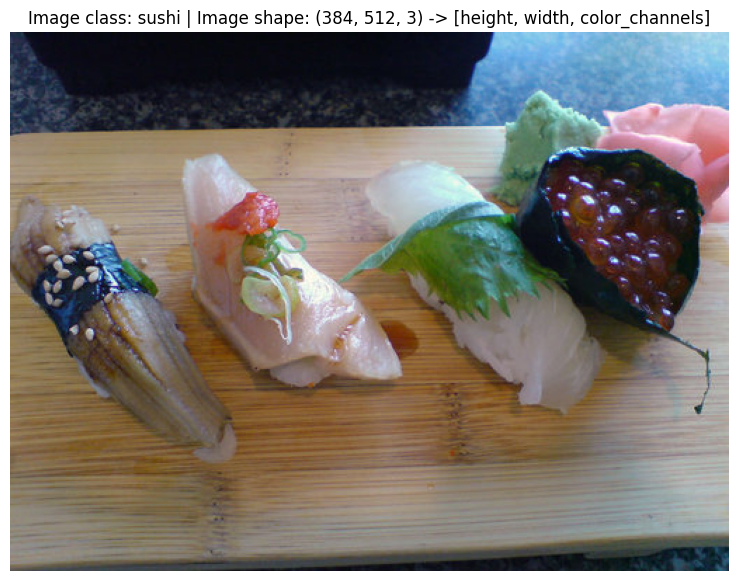

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False)

# Day 24

## 3. Transforming data

Before we can use our image idata with pytorch:
1. Turn your target data into tensors (in our case, numerical representation of our images).

2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these `dataset` and `dataloader`



In [11]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

In [12]:
# write a transform for image
data_transform = transforms.Compose([
    # Resize our images to 64x64
    transforms.Resize(size=(64,64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()
  ])

In [13]:
data_transform(img)

tensor([[[0.1373, 0.0824, 0.0431,  ..., 0.6549, 0.6353, 0.6275],
         [0.1569, 0.1294, 0.0510,  ..., 0.6000, 0.6078, 0.6118],
         [0.1490, 0.1569, 0.0824,  ..., 0.5843, 0.5843, 0.5843],
         ...,
         [0.5725, 0.5608, 0.5529,  ..., 0.1333, 0.1098, 0.1176],
         [0.5686, 0.5686, 0.5608,  ..., 0.0941, 0.0667, 0.1059],
         [0.4706, 0.4510, 0.4196,  ..., 0.0784, 0.0745, 0.1294]],

        [[0.1804, 0.1059, 0.0431,  ..., 0.8314, 0.8314, 0.8275],
         [0.1882, 0.1529, 0.0588,  ..., 0.8118, 0.8275, 0.8235],
         [0.1922, 0.1961, 0.0980,  ..., 0.8039, 0.8078, 0.8039],
         ...,
         [0.5451, 0.5451, 0.5373,  ..., 0.2157, 0.2039, 0.2235],
         [0.5373, 0.5412, 0.5333,  ..., 0.2000, 0.1647, 0.2353],
         [0.4353, 0.4196, 0.4000,  ..., 0.1882, 0.1765, 0.2627]],

        [[0.2824, 0.1804, 0.1020,  ..., 0.9137, 0.9216, 0.9255],
         [0.2941, 0.2549, 0.1216,  ..., 0.9176, 0.9216, 0.9255],
         [0.3020, 0.2980, 0.1686,  ..., 0.9255, 0.9216, 0.

In [14]:
data_transform(img).shape
data_transform(img).dtype

torch.float32

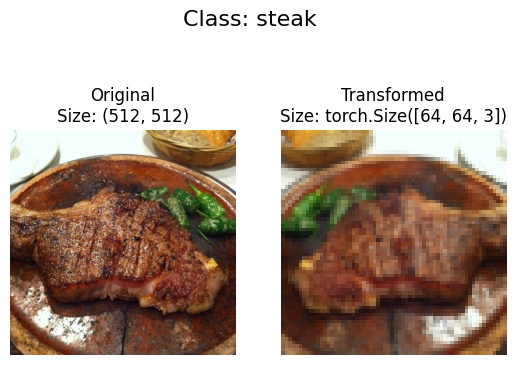

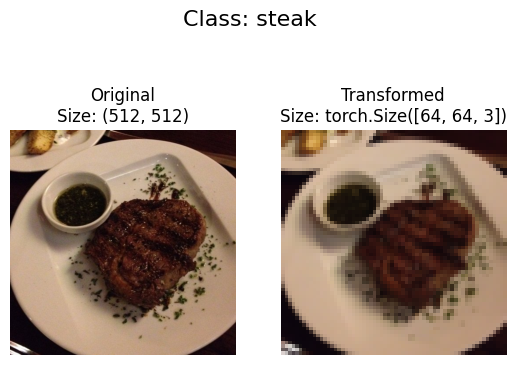

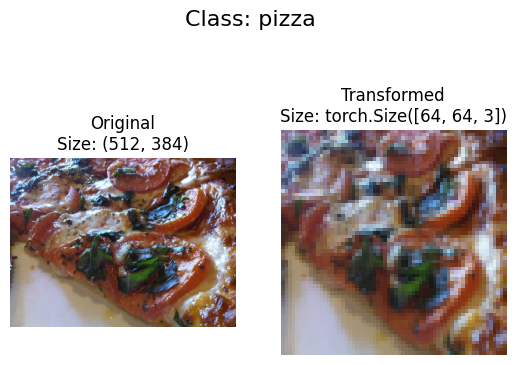

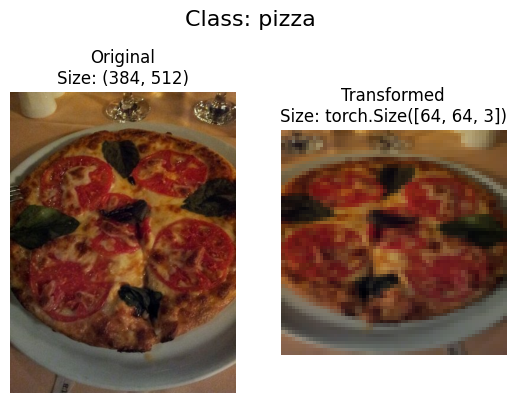

In [15]:
def plot_transformed_images(image_paths,transform, n=3, seed=None):
  """
  Selects random images form a path of images and loads/ transforms them then plots the original vs the transformed version.
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1,2,0)    # note we will need to change shape for matplotlib (C, H, W) => (H,W,C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nSize: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)



plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=4,
                        seed=42)



## 4. Option 1: Loading image data using  `ImageFolder`

We can load imag eclassification data using `torchvision.darasets.ImageFolder`

In [16]:
# Use ImageFolder to create dataset(s)

from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,    # a transform for the data
                                  target_transform=None)     # a transformfor the label/target
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizaa_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizaa_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

### Dataset Details:

1. **Training Dataset**:
    * Number of datapoints:255
    * Root location: `data/pizza_steak_sushi/train`
    * Transformations:
      * Resize: Images are resized to (64,64) pixels
      * RandomHorizontalFlip: Randomly flips the image horizontally with a probability of 0.5
      * ToTensor: Converts the image to a PyTorch tensor.

2. **Testing dataset**:
    * Number of datapints: 75
    * Root location: `data/pizza_steak_sushi/test`
    * Transformations:
       * Resize: Images are resized to (64 , 64) pixels.
       * RandomHorizontalFlip: Randomly flips the image horizonally with a probability of 0.5
       * ToTensor: Converts the image to PyTorch tensor


**Explanation :**

*  `ImageFolder`: This is a dataset class provided by `torchvision` that loads images from a directory. Each subdirectory in the root location to a class label.

*  `Transforms`:
  * `resize`: Ensures that all imafes have the same size, which is important for batching and feeding into the neural network.

  * `RandomHorizontalFlip`: This is a data augmentation technnique. By flipping the images horizontally at random, model is exposed to different variations of the training images, which can help improve generalization.

  * `ToTensor`: Converts the PIL Image or numpy.ndarray into a tensor, which is the format required by PyTorch for training and testing.



  ** Why use these Transforms?**
  *  **Resize**: Standardizes the input size, which simplifies the model architecture and training process.

  * **RandomHorizontalFlip**: Augments the dataset to include flipped versions of the images, making the model more robust to variations.

  * **ToTensor**: Converts images into a format suitable for PyTorch operations and neural network computations


By applying these transformations, the dataset becomes more manageable and suitable for training a neural network, as it ensures consistency in input size and introduces variability to improve model robustness.

In [17]:
# Get class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [18]:
 class_dict = train_data.class_to_idx
 class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [19]:
# Check the length of our dataset
len(train_data), len(test_data)

(225, 75)

# Day 25

In [20]:
# Index on the train_data Dataset to get a single image label
img, label=  train_data[0][0], train_data[0][1]
print(f"Image tensor:\n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"label datatype: {type(label)}")

Image tensor:
 tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.0

Original shape: torch.Size([3, 64, 64]) -> [colors_channel, height , width]


Text(0.5, 1.0, 'pizza')

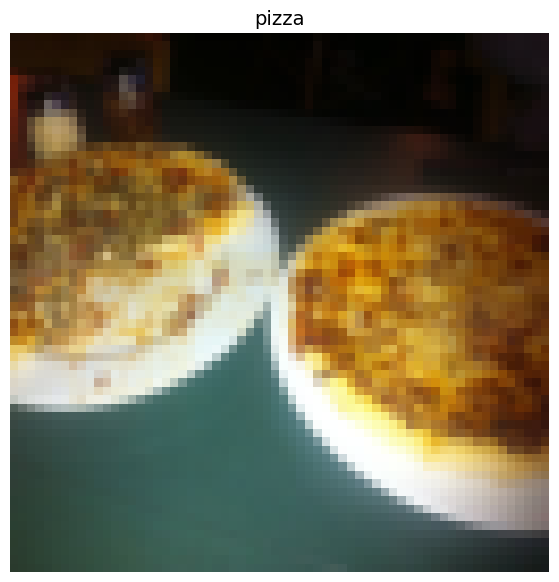

In [21]:
# Rearrange the order dimensions
img_permute = img.permute(1,2,0)

# Print out different shapes
print(f"Original shape: {img.shape} -> [colors_channel, height , width]")

# plot the image
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize=14)

### 4.1 Turn loaded images into `DataLoader`'s

A `DataLoader` is goig to help us turn our `Dataset`'s into iterables and we can customize the `batch_size` so our model can see `batch_size` images at a time.

In [22]:
# Turn train and test datasets into DataLoader's
from torch.utils.data import DataLoader
BATCH_SIZE=1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                            batch_size=BATCH_SIZE,
                            num_workers=1,
                            shuffle=False)
len(train_dataloader), len(test_dataloader)

(225, 75)

In [23]:
img, label = next(iter(train_dataloader))


# Batch size will now be 1, you can change the batch ize if you likee

print(f"Image shape: {img.shape} -> [batch_size, color_channels, height , width ]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height , width ]
Label shape: torch.Size([1])


## 5 option 2. Loading Image data with a custom `dataset`

1. Want to be able to laod images from a file
2. Want to be able to get class names from the dataset
3. Want to be able to get class as dictionary from the dataset


**Pros**:
* Can create a `Dataset` out of almost anything
* Not limited to PyTorch pre-built `dataset` functions

**cons**:
* Even though you could create `Dataset` out of almomst anything, it doesn't mean it will work...
* Using a custom `Dataset` often results in us writing more code, which could be prone to errors or performance issues

In [24]:
import os
import pathlib
import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List


In [25]:
  # Instancce of torchvision.datasets.ImageFolder()
  train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

# Day 26

### 5.1 Creating a helper functions to get class names

We want a function to:
1. Get the class names using `os.scandir()` to transverse a target directory (ideally the directory is in standard image classification format).
2. Raise an error if the class names aren't found (if this happens, there might be something wrong with the data )
3. Turn the class names into a dict and a list and return them.

In [26]:
# Setup path for target directory
target_directory = train_dir
print("Target dir: {target_directory}")

# Get the class names form the target directory

Class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory ))])
Class_names_found

Target dir: {target_directory}


['pizza', 'steak', 'sushi']

In [27]:
def find_classes(directory:str)-> Tuple[List[str], Dict[str,int]]:
  """Finds the class folder names in a target directory."""
  # 1. Get the class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # 2. Raise an error if class names could not be found
  if not classes:
    raise FileNotFoundError(f"Coudn't find any classes in {directory}...please check file structure")

  # 3. Create a dictionary of labels
  class_to_idx = {class_name: i for i , class_name in enumerate(classes)}

  return classes, class_to_idx

In [28]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`


To create our own custom dataset, we want to:

1. SUbclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory (the directory we'd like to get data from) as well as a transform if we'd like to transform our data.
3. Create several attributes:
  * paths - paths of our images
  * transform - the transform we'd like to use
  * classes - a list of the trarget classes
  * class_to_idx - a dict of the target classes mapped to integer labels

4. Create a function to `load_images()`, this function will open an image
5. Overwrite the `__len()__` method to return the length of our dataset
6. Overwrite the `__getitem()__` method to return a given  sample when passed an index


In [29]:
# 0.  Write a custom dataset class
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
  # 2. Initialize our custom dataset
  def __init__(self,targ_dir: str, transform=None):
    # 3. Create class attributes
    # get all of the image paths
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))

    # Setup transforms
    self.transforms = transform


    # Create classes and  and class_to_idx attributes
    self.classes, self.class_to_idx = find_classes(targ_dir)

  # 4. Create a function to load images
  def load_image(self, index:int) -> Image.Image:
    """Opens an image via a path and returns it."""

    image_path = self.paths[index]
    return Image.open(image_path)


  # 5. Overwrite __len__()
  def __len__(self) -> int:
    "Returns the total number of samples."
    return len(self.paths)

  # 6. Overwrite __getitem__() method to return a particular sample
  def __getitem__(self,index: int) -> Tuple[torch.Tensor, int]:
    "Return one sample of data , data and label (x,y )."
    img = self.load_image(index)
    class_name = self.paths[index].parent.name
    class_idx = self.class_to_idx[class_name]

    # Transform if necessary
    if self.transforms:
      return self.transforms(img), class_idx # return data, label (x,y)
    else:
      return img, class_idx  # return untransformed image and label

In [30]:
# create a transform
from torchvision import transforms
train_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
                                      transforms.Resize(size=(64,64)),
                                      transforms.ToTensor(),
                                      ])

In [31]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)

In [32]:
train_data_custom

In [33]:
len(train_data), len(train_data_custom)

(225, 225)

In [34]:
len(test_data), len(test_data_custom)

(75, 75)

In [35]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [36]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [37]:
# check for equality between original ImageFolder and ImageFoldercustom
print(train_data_custom.classes == train_data.classes)
print(test_data_custom.classes == test_data.classes)

True
True


# Day 27

### 5.3 Create a function to display random images


1. Take in a `Dataset` and a number of other parameters such as class names and how many images to visualize.
2. To prevent the display getting out of hand, let's cap the number of images to see at 10.
3. Set the jrandom seed for reproducibility
4. Get a list of random sample indexes from the target dataset.
5. Setup a matplotlib plot.
6. Loop through the random sample images and plot them with  matplotlib (HWC)

In [38]:
 # Create a function to take in a dataset
 def display_random_images(dataset: torch.utils.data.Dataset,
                           classes: List[str]= None,
                           n: int = 10,
                           display_shape: bool = True,
                           seed: int = None):
   # 2. Adjust display if n is too high
  if n > 10:
    n = 10
    display_shape = False
    print(f"For display, purposes, n shouldn't be larger that 10, setting to 10 and removing shape display")


  # 3. Set the seed
  if seed:
    random.seed(seed)


  # 4. Get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)), k= n)

  # 5. Setup plot
  plt.figure(figsize=(16,8))

  # 6. Loop through random indexes and plot them with matplotlib
  for i, target_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[target_sample][0], dataset[target_sample][1]

    # 7. Adjust tensor dimensions for plotting
    targ_image_adjust = targ_image.permute(1,2,0)  # [color_channels, height, width] -> [height, width, color_channels]

    # Plot adjusted samples
    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nshape: {targ_image_adjust.shape}"
    plt.title(title)

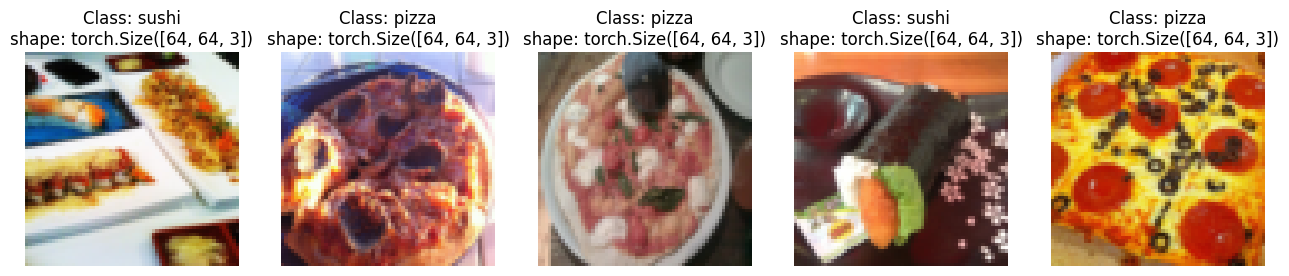

In [39]:
# Display random images from the ImageFolder created dataset
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=42)

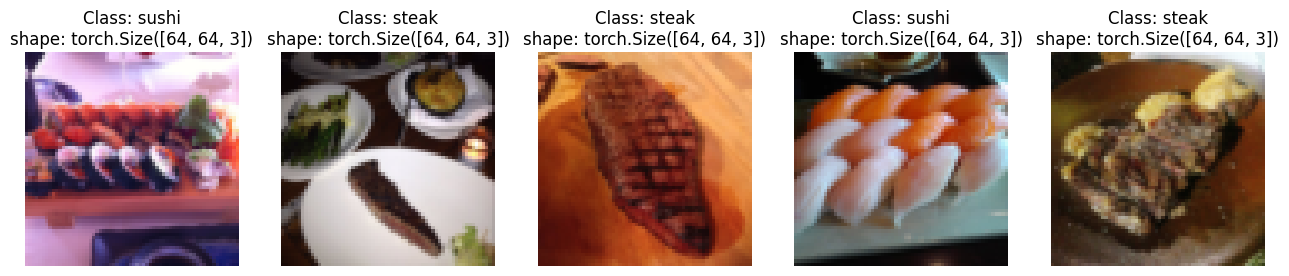

In [40]:
# Display random images from the ImageFolderCustom Dataset
display_random_images(train_data_custom,
                      n=5,
                      classes=class_names,
                      seed=42)

### 5.4 Trun custom loaded images into `DataLoader's`

In [41]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7d3052a73be0>,
 <torch.utils.data.dataloader.DataLoader at 0x7d3052a70730>)

In [42]:
# Get image and label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))

#  Print out the shapes
img_custom.shape, label_custom.shape


(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## 6. Data Augmentation

Data augmentation is the process of artificially adding diversity to your training data.

In the case of image data, this may mean applying various image transformations to the training images.

Let's take a look at one particular type of data augmentation used to train PyTorch vision models to state of the art levels...



In [43]:
# Let;s look at trivailaugment
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])


test_transform = transforms.Compose([transforms.Resize(size=(224,224)),
                                     transforms.ToTensor()])

In [44]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizaa_steak_sushi/train/steak/560503.jpg'),
 PosixPath('data/pizaa_steak_sushi/train/steak/239025.jpg'),
 PosixPath('data/pizaa_steak_sushi/train/steak/2013535.jpg'),
 PosixPath('data/pizaa_steak_sushi/train/steak/167069.jpg'),
 PosixPath('data/pizaa_steak_sushi/train/steak/2606444.jpg'),
 PosixPath('data/pizaa_steak_sushi/train/steak/2287136.jpg'),
 PosixPath('data/pizaa_steak_sushi/train/steak/2707522.jpg'),
 PosixPath('data/pizaa_steak_sushi/train/steak/165639.jpg'),
 PosixPath('data/pizaa_steak_sushi/train/steak/1761285.jpg'),
 PosixPath('data/pizaa_steak_sushi/train/steak/2878151.jpg')]

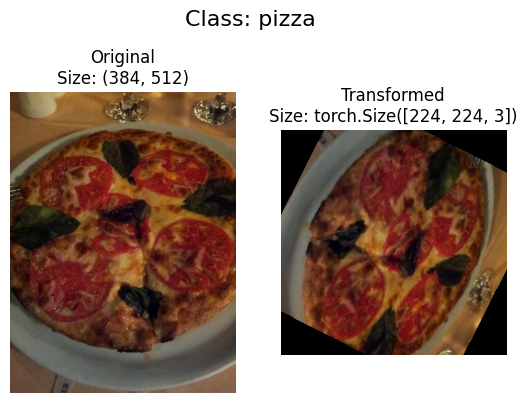

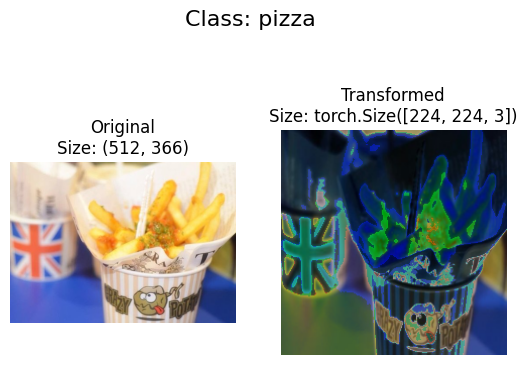

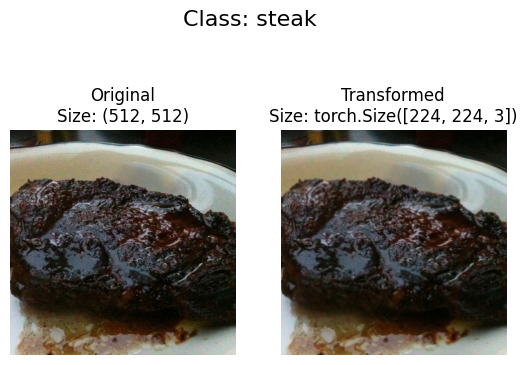

In [45]:
# Plot random transformed images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transform,
    n=3,
    seed=None)

# Day 28

## 7. Model 0: Tiny VGG without data augmentation

Let's replicate TinyVGG architecture form the CNN Explainer website.

#### 7.1 Creating transforms and loading data for Model 0

In [46]:
# Create siple transform
simple_transform = transforms.Compose([
     transforms.Resize(size=(64,64)),
     transforms.ToTensor()
])

In [47]:
# 1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)

test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=simple_transform
                                        )


# 2. Turn the datasets into DataLoaders
import os
from torch.utils.data import DataLoader


# Setup  batch size and number of works
Batch_size = 32
NUM_WORKERS = os.cpu_count()


# Create DataLoader's
train_datalaoder_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)

test_datalaoder_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)



 ### 7.2. Create TinyVGG model class

In [71]:
 class TinyVGG(nn.Module):
  """
  Model architecture copying TinyVGG From CNN Explainer
  """
  def __init__(self, input_shape: int,
               hidden_units: int,
               output_shape: int) -> None:

    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2 )
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2 )
    )

    self.classifier = nn.Sequential(nn.Flatten(),
                                    nn.Linear(in_features=hidden_units * 13 * 13,
                                              out_features=output_shape))


  def forward(self, x):
    x = self.conv_block_1(x)
    print(x.shape)
    x = self.conv_block_2(x)
    print(x.shape)
    x = self.classifier(x)
    print(x.shape)
    return x
    # return self.classifier(self.conv_block_2(self.conv_block_1(x)))     #  beifts from operator fusion

In [72]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3,     # number of color channels in our image data
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### 7.3 Try a forward pass ona single image (to test the model)


In [73]:
# Get a single image batch
image_batch, label_batch = next(iter(train_datalaoder_simple))
image_batch.shape, label_batch.shape


(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [74]:
model_0(image_batch.to(device))

torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])
torch.Size([32, 3])


tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4668e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9131e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6415e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0239e-02, -4.7979e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1816e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7225e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3995e-03,  9.4990e-03],
        [ 2.2101e-02, -4.1469e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.1665e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02